##Loading and Importing Libraries


In [2]:
!pip install tensorflow scikeras

INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.


In [3]:
import pandas
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Concatenate, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

##Importing Data


In [4]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "http://frasca.di.unimi.it/MLDNN/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

In [5]:
imgs.shape, masks.shape

((1305, 256, 256, 3), (1305, 256, 256, 1))

Now, I plot some random images with their relative mask to get to understand the context of the task

In [6]:
def plot_img(idx):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(imgs[idx])
  axs[1].imshow(masks[idx])

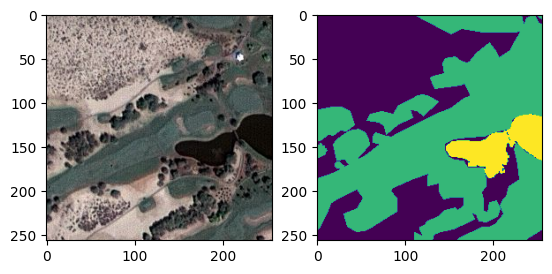

In [7]:
idx = random.randint(0, imgs.shape[0]-1)
plot_img(idx)

So, the images are urban images and the goal is to locate different elements of the urban environment

##Data Preprocessing

Values of the images pixels

In [8]:
imgs.max(), imgs.min()

(255, 0)

Values of the masks pixels

In [9]:
masks.max(), masks.min()

(5, 0)

Rescale images values in the [0,1] interval

In [10]:
imgs.dtype

dtype('uint8')

In [11]:
imgs = imgs.astype('float64')

In [12]:
imgs /= 255
imgs.max(), imgs.min()

(1.0, 0.0)

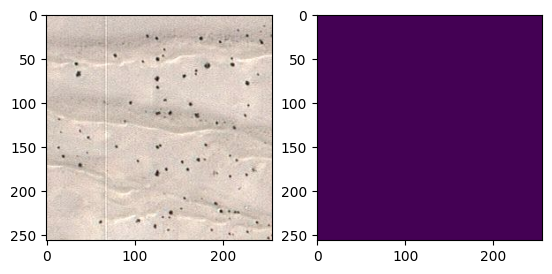

In [13]:
plot_img(random.randint(0,imgs.shape[0]-1))

In [14]:
img_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3])

In [15]:
n_classes = len(np.unique(masks))

##Classes balance

In [16]:
unique, counts = np.unique(masks, return_counts=True)
print(np.asarray((unique, counts)).T)

[[       0 11698953]
 [       1 45571963]
 [       2  7985171]
 [       3  8743823]
 [       4 11116730]
 [       5   407840]]


Class 5 is under represented and class 1 is over represented, so I will adjust class weights in the loss function accordingly

In [20]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(masks), y=masks.reshape(-1))
class_weights

array([ 1.21840647,  0.31278179,  1.78506885,  1.63018853,  1.28221878,
       34.95017654])

In [21]:
class_weights = {i:weight for i, weight in enumerate(class_weights) }
class_weights

{0: 1.2184064676556954,
 1: 0.31278178646814053,
 2: 1.785068848243826,
 3: 1.6301885342372553,
 4: 1.282218781961962,
 5: 34.95017653981954}

##Train-Test Splitting

In [22]:
X_train, X_test, y_train, y_test = train_test_split(imgs, masks, test_size=.2)

In [23]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1044, 256, 256, 3) (261, 256, 256, 3)
(1044, 256, 256, 1) (261, 256, 256, 1)


##Custom Utility Functions and Classes

Custom Intersection over Union in order to use it also as training metric

In [24]:
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

Function to evaluate accuracy and Intersection over Union of a model on a validation set

In [25]:
def evaluate_model(model, X_tra, y_tra, X_val, y_true, batch_size, epochs):
  model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs)
  y_hat = model.predict(X_val)
  y_pred = tf.argmax(y_hat, axis=-1)

  m_iou = CustomMeanIoU(num_classes=n_classes)
  m_iou.update_state(y_true, y_hat)
  iou = m_iou.result().numpy()

  acc = accuracy_score(y_true.numpy().reshape(-1), y_pred.numpy().reshape(-1))

  return acc, iou

In [26]:
def visualize_predictions(X_true, y_true, y_pred, idx):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(X_true[idx])
    axs[0].set_title("Image")
    axs[1].imshow(y_true[idx])
    axs[1].set_title("Ground Truth")
    axs[2].imshow(y_pred[idx])
    axs[2].set_title("Prediction")
    plt.show()

##Model Architecture
I'm using a Fully Convolutional Neural Network to solve the task, having both as input and as output images. So I have to build the structure of the encoder and that of the decoder, connecting them through a bottleneck. For this scope I will only include in the network layers of the following kinds: Conv2d, MaxPool2d, Conv2dTranspose and Concatenate layers to include the skip connections in the network.
I will firstly define a convolutional block and an transpose convolutional block which I will use as main components respectively of the encoder and of the decoder; in this way it will be easier to scale up the model if needed  

In [27]:
# CONVOLUTIONAL BLOCK
# I'm assuming that the blocks have a fixed number of layers (2 Conv2D, 1 MaxPool2D)
# and that all the layers in the block have the same number of filters (n_filters)

def convolutional_block(x, n_filters:int, kernel_size:tuple[int]=(3, 3), padding:str="same", pool_size:tuple[int]=(2,2)):
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(x)
  conv = Dropout(.2)(conv)
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(conv)
  conv = BatchNormalization()(conv, training=False)

  pool = MaxPool2D(pool_size=pool_size)(conv)

  return conv, pool

# TRANSPOSE CONVOLUTIONAL BLOCK
# I'm assuming that the blocks have a fixed number of layers (1 Conv2DTranspose, 2 Conv2D + skip connection)
# and that all the Conv2D layers in the block have the same number of filters (n_filters_conv);

def transpose_block(x, skip, n_filters:int, kernel_size:tuple[int]=(3, 3), padding:str="same", stride_trans:tuple[int]=(2,2)):
  trans_conv = Conv2DTranspose(n_filters, kernel_size=(2,2), strides=stride_trans, padding=padding)(x)
  conc = Concatenate([skip, trans_conv])
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(trans_conv)
  conv = Dropout(.2)(conv)
  conv = Conv2D(n_filters, kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(conv)

  return conv

In [28]:
def FCNN(img_shape:tuple[int], n_classes:int, n_filters_list:list[int], \
         kernel_size:tuple[int]=(3, 3), padding:str="same", pool_size:tuple[int]=(2,2)):
  input = Input(shape=img_shape)
  conv_layers = []
  pool_layers = []
  decoder_layers = []

  # ENCODER
  for i, n_filters in enumerate(n_filters_list):
    if i == 0:
      conv, pool = convolutional_block(input, n_filters, kernel_size, padding, pool_size)
      conv_layers.append(conv)
      pool_layers.append(pool)
    else:
      conv, pool = convolutional_block(pool_layers[-1], n_filters, kernel_size, padding, pool_size)
      conv_layers.append(conv)
      pool_layers.append(pool)

  # BOTTLENECK
  # I'm assuming a fixed size bottleneck with 2 layers
  # with the same number of filters of the last encoding block (or first decoding block)
  bot = Conv2D(n_filters_list[-1], kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(pool_layers[-1])
  bot = Conv2D(n_filters_list[-1], kernel_size=kernel_size, padding=padding, activation='relu', kernel_initializer='he_normal')(bot)

  # DECODER
  for i, n_filters in enumerate(n_filters_list):
    if i == 0:
      conv = transpose_block(bot, conv_layers[-(i+1)], n_filters_list[-(i+1)], kernel_size, padding)
      decoder_layers.append(conv)
    else:
      conv = transpose_block(decoder_layers[-1], conv_layers[-(i+1)], n_filters_list[-(i+1)], kernel_size, padding)
      decoder_layers.append(conv)

  # OUTPUT layers
  output = Conv2D(n_classes, kernel_size=(1,1), padding=padding, activation='softmax')(decoder_layers[-1])

  model = Model(inputs=[input], outputs=[output])
  model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', CustomMeanIoU(num_classes=n_classes, name='IoU')])
  return model

##Base Model
Now I train a base model and evaluate his performance to keep it as term of comparison later in the work. In this stage I'm not trying to optimize any parameter.

In [29]:
n_filters_list = [16, 32, 64]
model = FCNN(img_shape=img_shape,
             n_classes=n_classes,
             n_filters_list=n_filters_list)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 dropout (Dropout)           (None, 256, 256, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                          

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10, class_weight=class_weights)

Epoch 1/10
21/33 [==================>...........] - ETA: 3:09 - loss: 1.7869 - accuracy: 0.4365 - IoU: 0.1683

In [23]:
y_hat = model.predict(X_test)
y_pred = tf.expand_dims(tf.argmax(y_hat, axis=-1), axis=-1)

9/9 [==============================] - 2s 125ms/step


In [24]:
print(accuracy_score(y_test.reshape(-1), y_pred.numpy().reshape(-1)))
m_iou = CustomMeanIoU(num_classes=n_classes)
m_iou.update_state(y_test, y_hat)
print(m_iou.result().numpy())

0.7523048956275443
0.40403578


##Hyperparameter Tuning
While I'm displaying both accuracy and Intersection over Union as performance metrics \\
**I will only consider accuracy since I did not mention Intersection over Union in the written part of the exam** \\
It would be preferable, though, due to the semantic segmentation nature of the task, to take Intersection over Union in consideration as main metric

In [25]:
param_grid = {
    'n_filters_list' : [[32, 64], [64, 128], [16, 32, 64], [32, 64, 128], [16, 32, 64, 128] ],
    'batch_size' : [16, 32]
}

I'm writing a custom grid_search since the scikit_learn implementation is not optimal for handling image kind of data

In [26]:
import itertools

def grid_search(model_func, img_shape, n_classes, param_grid, X, y, epochs, val_size=.2, random_state=42):
  # Generate all combinations of parameters
  param_combinations = list(itertools.product(*param_grid.values()))
  print(f'Searching in {len(param_combinations)} combinations')

  best_score = 0
  best_params = None
  best_model = None

  X_tra, X_val, y_tra, y_val = train_test_split(X, y, test_size=val_size, shuffle=True,random_state=random_state)

  # converting to tf.tensor for ram optimization
  X_tra = tf.convert_to_tensor(X_tra)
  X_val = tf.convert_to_tensor(X_val)
  y_tra = tf.convert_to_tensor(y_tra)
  y_val = tf.convert_to_tensor(y_val)

  for idx, params in enumerate(param_combinations):
    current_params = dict(zip(param_grid.keys(), params))
    print(f'Configuration {idx+1}/{len(param_combinations)} -> current parameters: ', current_params)
    batch_size = current_params.pop('batch_size')
    model = model_func(img_shape=img_shape, n_classes=n_classes,
                  n_filters_list=current_params['n_filters_list'])

    # Evaluating the current model
    print('Evaluating...')
    acc, iou = evaluate_model(model, X_tra, y_tra, X_val, y_val, batch_size, epochs)
    print(f'Validation accuracy: {acc}, Validation IoU: {iou}')

    # Here I'm only considering accuracy to select the best model
    if acc > best_score:
      best_score = acc
      best_params = {**current_params, 'batch_size': batch_size}
      best_model = model

  print("Best Score:", best_score)
  print("Best Params:", best_params)
  return best_model, best_params, best_score

In [27]:
# Partial datasets to be de-commented in case of hardware constraints
partial_X_train = X_train[:300]
partial_y_train = y_train[:300]

best_model, best_params, best_score = grid_search(model_func=FCNN,
                                                  img_shape=img_shape,
                                                  n_classes = n_classes,
                                                  param_grid=param_grid,
                                                  X=partial_X_train,
                                                  y=partial_y_train,
                                                  epochs=6)

Searching in 10 combinations
Configuration 1/10 -> current parameters:  {'n_filters_list': [32, 64], 'batch_size': 16}
Evaluating...
Epoch 1/6
15/15 [==============================] - 19s 271ms/step - loss: 1.3430 - accuracy: 0.4818 - IoU: 0.0906
Epoch 2/6
15/15 [==============================] - 4s 275ms/step - loss: 1.1631 - accuracy: 0.5659 - IoU: 0.1502
Epoch 3/6
15/15 [==============================] - 4s 270ms/step - loss: 1.0867 - accuracy: 0.6082 - IoU: 0.2036
Epoch 4/6
15/15 [==============================] - 4s 270ms/step - loss: 1.0506 - accuracy: 0.6213 - IoU: 0.2142
Epoch 5/6
15/15 [==============================] - 4s 274ms/step - loss: 0.9986 - accuracy: 0.6509 - IoU: 0.2684
Epoch 6/6
2/2 [==============================] - 6s 3s/step
Validation accuracy: 0.7091761271158854, Validation IoU: 0.2627957761287689
Configuration 2/10 -> current parameters:  {'n_filters_list': [32, 64], 'batch_size': 32}
Evaluating...
Epoch 1/6
8/8 [==============================] - 13s 509ms/st

2/2 [==============================] - 0s 250ms/step
Validation accuracy: 0.6664105733235677, Validation IoU: 0.1908172219991684
Configuration 5/10 -> current parameters:  {'n_filters_list': [16, 32, 64], 'batch_size': 16}
Evaluating...
Epoch 1/6
15/15 [==============================] - 12s 167ms/step - loss: 1.5028 - accuracy: 0.3673 - IoU: 0.0883
Epoch 2/6
15/15 [==============================] - 3s 175ms/step - loss: 1.2301 - accuracy: 0.5116 - IoU: 0.0870
Epoch 3/6
15/15 [==============================] - 3s 168ms/step - loss: 1.1460 - accuracy: 0.5446 - IoU: 0.1333
Epoch 4/6
15/15 [==============================] - 3s 169ms/step - loss: 1.0927 - accuracy: 0.6103 - IoU: 0.1953
Epoch 5/6
15/15 [==============================] - 3s 169ms/step - loss: 1.0750 - accuracy: 0.6163 - IoU: 0.1913
Epoch 6/6
15/15 [==============================] - 3s 170ms/step - loss: 1.0494 - accuracy: 0.6294 - IoU: 0.2112


2/2 [==============================] - 2s 2s/step
Validation accuracy: 0.5032063802083333, Validation IoU: 0.13519194722175598
Configuration 6/10 -> current parameters:  {'n_filters_list': [16, 32, 64], 'batch_size': 32}
Evaluating...
Epoch 1/6
8/8 [==============================] - 8s 319ms/step - loss: 1.8162 - accuracy: 0.1901 - IoU: 0.0550
Epoch 2/6
8/8 [==============================] - 3s 317ms/step - loss: 1.5264 - accuracy: 0.4365 - IoU: 0.0873
Epoch 3/6
8/8 [==============================] - 3s 325ms/step - loss: 1.3723 - accuracy: 0.5135 - IoU: 0.0863
Epoch 4/6
8/8 [==============================] - 3s 318ms/step - loss: 1.2526 - accuracy: 0.5163 - IoU: 0.0861
Epoch 5/6
8/8 [==============================] - 3s 320ms/step - loss: 1.1702 - accuracy: 0.5165 - IoU: 0.0861
Epoch 6/6
2/2 [==============================] - 0s 53ms/step
Validation accuracy: 0.6230575561523437, Validation IoU: 0.10384292155504227
Configuration 7/10 -> current parameters:  {'n_filters_list': [32, 64, 

##Refitting the best model on the full training dataset

In [28]:
best_model = FCNN(img_shape,
                  n_classes,
                  n_filters_list=best_params['n_filters_list'])

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=6,
                                            mode='min',
                                            restore_best_weights=True)

best_model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=100, validation_split=.2, callbacks=[callback])

Epoch 1/100
53/53 [==============================] - 26s 393ms/step - loss: 1.1787 - accuracy: 0.5476 - IoU: 0.1342 - val_loss: 1.0234 - val_accuracy: 0.6893 - val_IoU: 0.2419
Epoch 2/100
53/53 [==============================] - 15s 285ms/step - loss: 0.9680 - accuracy: 0.6706 - IoU: 0.2882 - val_loss: 0.8388 - val_accuracy: 0.7443 - val_IoU: 0.3128
Epoch 3/100
53/53 [==============================] - 15s 276ms/step - loss: 0.7537 - accuracy: 0.7365 - IoU: 0.3841 - val_loss: 0.9858 - val_accuracy: 0.6854 - val_IoU: 0.2639
Epoch 4/100
53/53 [==============================] - 15s 288ms/step - loss: 0.7199 - accuracy: 0.7442 - IoU: 0.3981 - val_loss: 0.6974 - val_accuracy: 0.7592 - val_IoU: 0.3644
Epoch 5/100
53/53 [==============================] - 15s 279ms/step - loss: 0.6881 - accuracy: 0.7546 - IoU: 0.4153 - val_loss: 0.8447 - val_accuracy: 0.7215 - val_IoU: 0.3201
Epoch 6/100
53/53 [==============================] - 15s 288ms/step - loss: 0.6676 - accuracy: 0.7615 - IoU: 0.4299 - va

In [30]:
y_hat = best_model.predict(X_test)
y_pred = tf.expand_dims(tf.argmax(y_hat, axis=-1), axis=-1)

print(np.unique(y_test))
print(np.unique(y_pred))

9/9 [==============================] - 2s 208ms/step
[0 1 2 3 4 5]
[0 1 2 3 4]


In [31]:
accuracy_score(y_test.reshape(-1), y_pred.numpy().reshape(-1))

0.8266468851959111

In [32]:
m_iou = MeanIoU(num_classes=n_classes)
m_iou.update_state(y_test, y_pred)
m_iou.result().numpy()

0.54571384

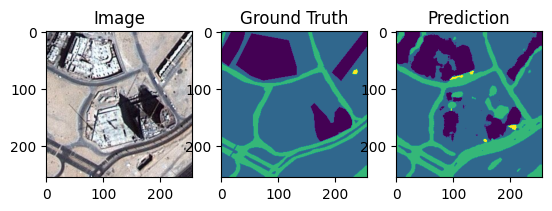

In [40]:
visualize_predictions(X_test, y_test, y_pred, random.randint(0,len(y_test)-1))